In [100]:
%matplotlib inline
from __future__ import division
import warnings
warnings.filterwarnings('ignore')
warnings.showwarning = False

In [219]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn import preprocessing

In [102]:
from pylab import rcParams
from IPython.display import clear_output
rcParams['figure.figsize'] = 16, 8
pd.options.display.max_columns = 999

In [103]:
bank_data = pd.read_csv('../../data/bank-full.csv', sep=';')
bank_data.shape

(45211, 17)

In [104]:
bank_data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

1. age (numeric)
1. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
1. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
1. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
1. default: has credit in default? (categorical: 'no','yes','unknown')
1. housing: has housing loan? (categorical: 'no','yes','unknown')
1. loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
1. contact: contact communication type (categorical: 'cellular','telephone') 
1. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
1. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
1. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
1. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
1. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
1. previous: number of contacts performed before this campaign and for this client (numeric)
1. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
1. emp.var.rate: employment variation rate - quarterly indicator (numeric)
1. cons.price.idx: consumer price index - monthly indicator (numeric) 
1. cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
1. euribor3m: euribor 3 month rate - daily indicator (numeric)
1. nr.employed: number of employees - quarterly indicator (numeric)

First, split variables into categorical and numerical

In [105]:
response = 'y'
categorical_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day', 'poutcome']
numerical = [v for v in bank_data.columns.values if v not in categorical_vars and v != response]
len(categorical_vars), len(numerical)

(10, 6)

Now lets check numerical variables

In [106]:
bank_data[numerical].describe()

,age,balance,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


Negative balance? I have no idea what it means...

In [107]:
bank_data[bank_data.balance < 0].shape

(3766, 17)

In [108]:
bank_data[numerical][:5]

,age,balance,duration,campaign,pdays,previous
0,58,2143,261,1,-1,0
1,44,29,151,1,-1,0
2,33,2,76,1,-1,0
3,47,1506,92,1,-1,0
4,33,1,198,1,-1,0


No handles with labels found to put in legend.


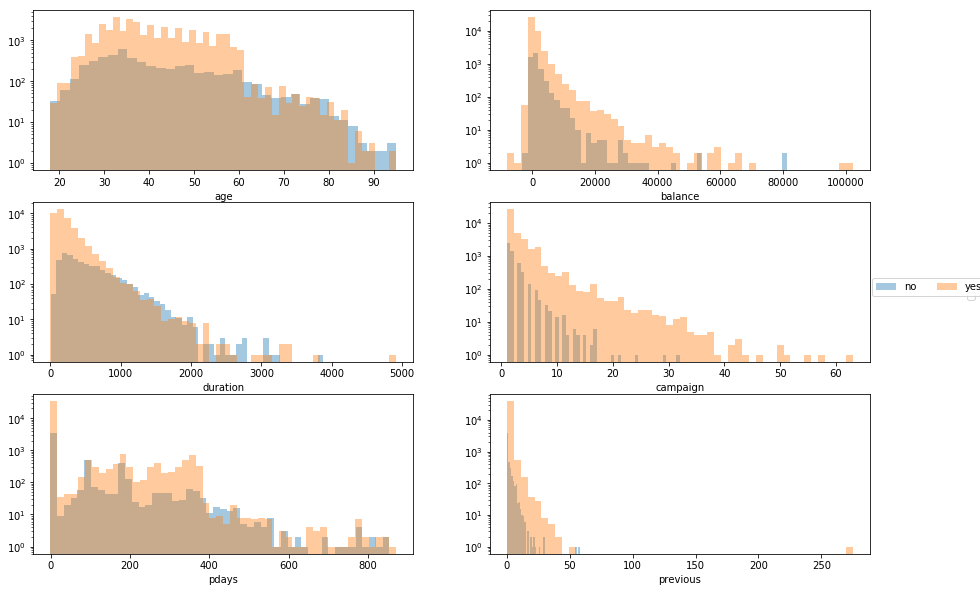

In [172]:
n_cols = 2

f, ax = plt.subplots(len(numerical) // n_cols, n_cols, figsize=(15,10))
f.legend(loc=7)

for i, var in enumerate(bank_data[numerical]):
    _ = sns.distplot(bank_data[bank_data.y == 'yes'][var], kde=False, ax=ax[i // n_cols][i % n_cols])
    _ = sns.distplot(bank_data[bank_data.y == 'no'][var], kde=False, ax=ax[i // n_cols][i % n_cols])
    ax[i // n_cols][i % n_cols].set_yscale('log')
    
f.legend( np.unique(bank_data.y), loc = (0.89, 0.5), ncol=5)

No handles with labels found to put in legend.


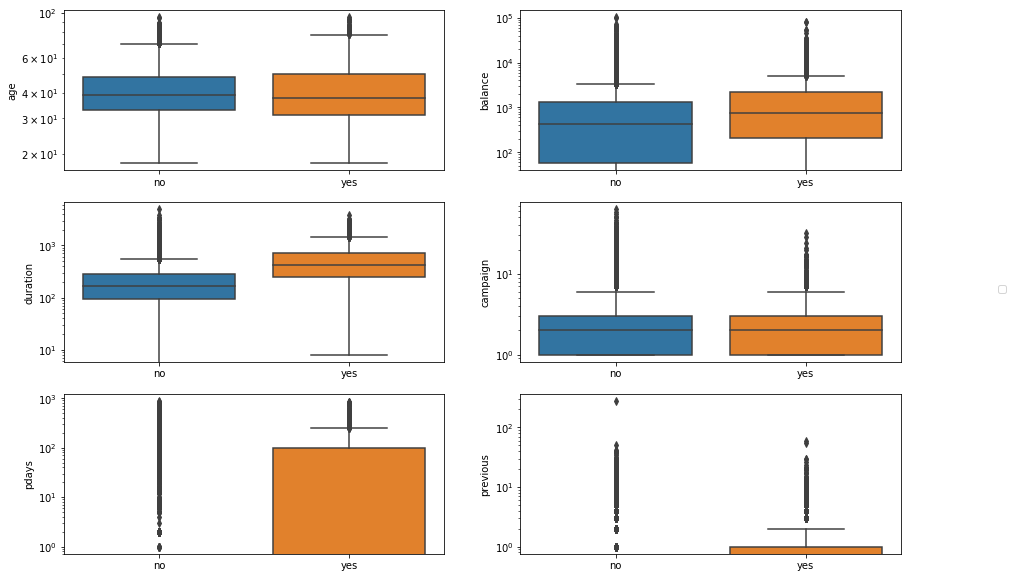

In [187]:
n_cols = 2

f, ax = plt.subplots(len(numerical) // n_cols, n_cols, figsize=(15,10))
f.legend(loc=7)

for i, var in enumerate(bank_data[numerical]):
    g = sns.boxplot(data=bank_data, y=var, x='y', ax=ax[i // n_cols][i % n_cols])
    g.set_yscale('log')
    g.set_xlabel('')
#     g.axes.get_xaxis().set_visible(False)


now lets take a look at categorical variables

In [126]:
bank_data[categorical_vars][:5]

,job,marital,education,default,housing,loan,contact,month,day,poutcome
0,management,married,tertiary,no,yes,no,unknown,may,5,unknown
1,technician,single,secondary,no,yes,no,unknown,may,5,unknown
2,entrepreneur,married,secondary,no,yes,yes,unknown,may,5,unknown
3,blue-collar,married,unknown,no,yes,no,unknown,may,5,unknown
4,unknown,single,unknown,no,no,no,unknown,may,5,unknown


No handles with labels found to put in legend.


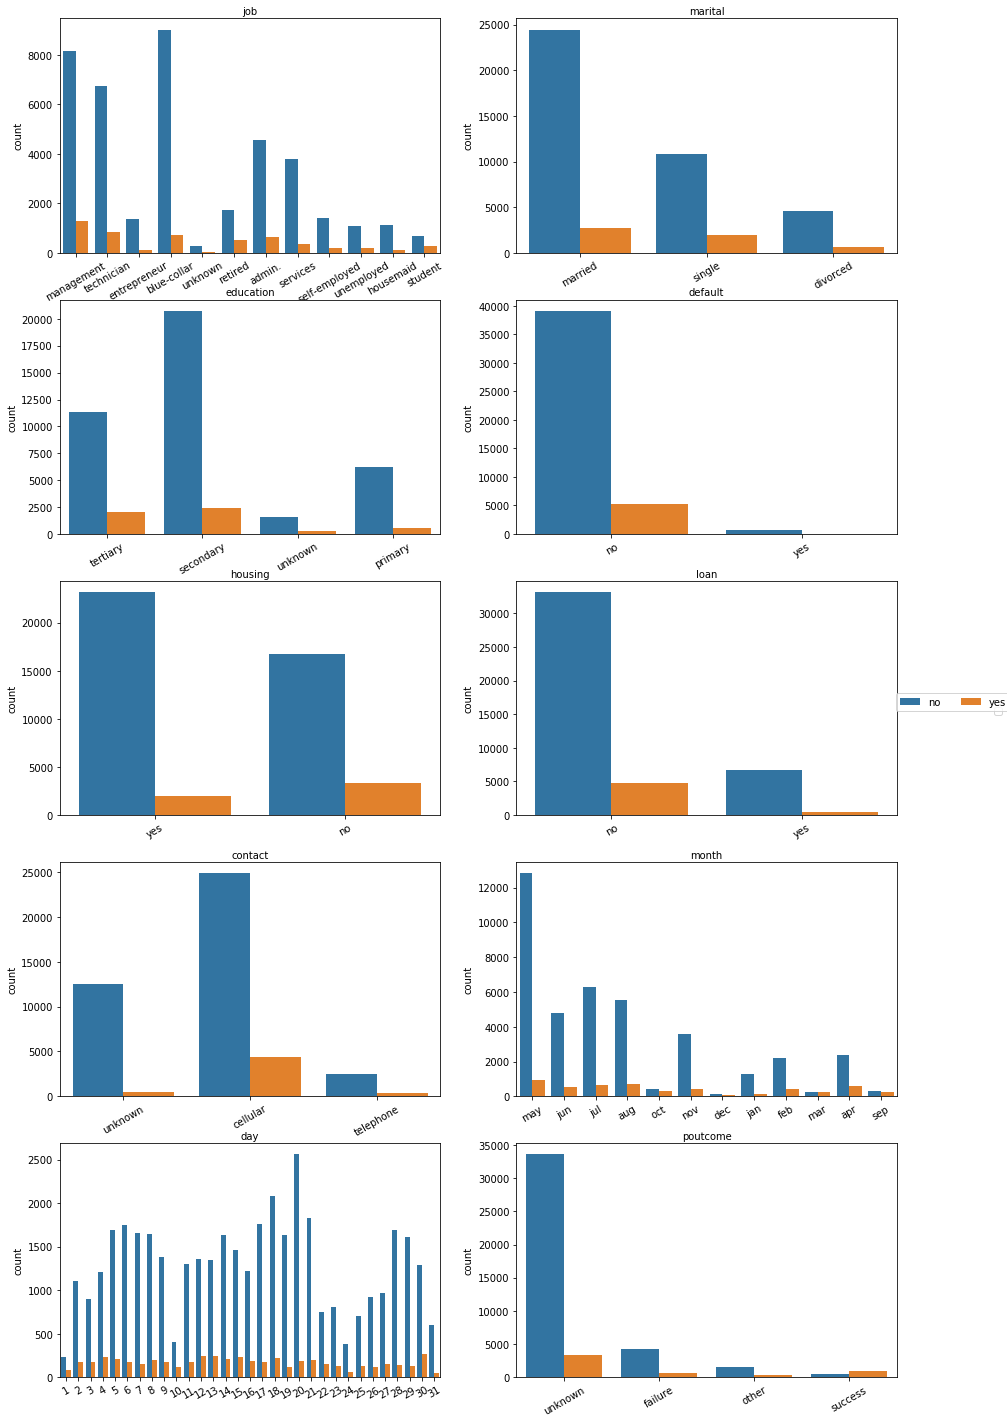

In [173]:
n_cols = 2

f, ax = plt.subplots(len(categorical_vars) // n_cols, n_cols, figsize=(15,25))
f.legend(loc=7)

for i, var in enumerate(bank_data[categorical_vars]):
    g = sns.countplot(x=var, hue="y", data=bank_data, ax=ax[i // n_cols][i % n_cols])
    g.legend_.remove()
    g.set_xticklabels(g.get_xticklabels(), rotation=30)
#     g.xaxis.tick_top()
    g.xaxis.set_label_position('top') 
    
f.legend(np.unique(bank_data.y), loc = (0.89, 0.5), ncol=5)

In [189]:
bank_data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [230]:
def dummy_transform(data):
    le = preprocessing.LabelEncoder()
    le.fit(data[response])
    y = pd.Series(le.transform(data[response]), name='y')
    return pd.concat([pd.get_dummies(data[categorical_vars]), data[numerical], y], axis=1)

In [236]:
dummy_transform(pd.read_csv('../../data/bank-balanced-train.csv')).to_csv('../../data/bank-balanced-train-d.csv', index=False)
dummy_transform(pd.read_csv('../../data/bank-unbalanced-train.csv')).to_csv('../../data/bank-unbalanced-train-d.csv', index=False)
dummy_transform(pd.read_csv('../../data/bank-test.csv')).to_csv('../../data/bank-test-d.csv', index=False)

In [195]:
from sklearn.ensemble import RandomForestClassifier

In [237]:
clf = RandomForestClassifier(max_depth=2, random_state=0)

In [241]:
X_y = dummy_transform(bank_data)
y = X_y[response]
X = X_y.drop(response, axis=1)

In [242]:
clf.fit(X, y) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [243]:
features = pd.DataFrame(
    {'feature_importances' : pd.Series(clf.feature_importances_), 'variable': pd.Series(X.columns)})

In [244]:
first_50 = features.sort_values(by='feature_importances', ascending=False).head(50)
first_50

,feature_importances,variable
43,0.293836,poutcome_success
47,0.224175,duration
45,0.195444,age
49,0.101335,pdays
28,0.064956,contact_unknown
26,0.036583,contact_cellular
15,0.020444,marital_single
46,0.015698,balance
36,0.015033,month_mar
23,0.013534,housing_yes


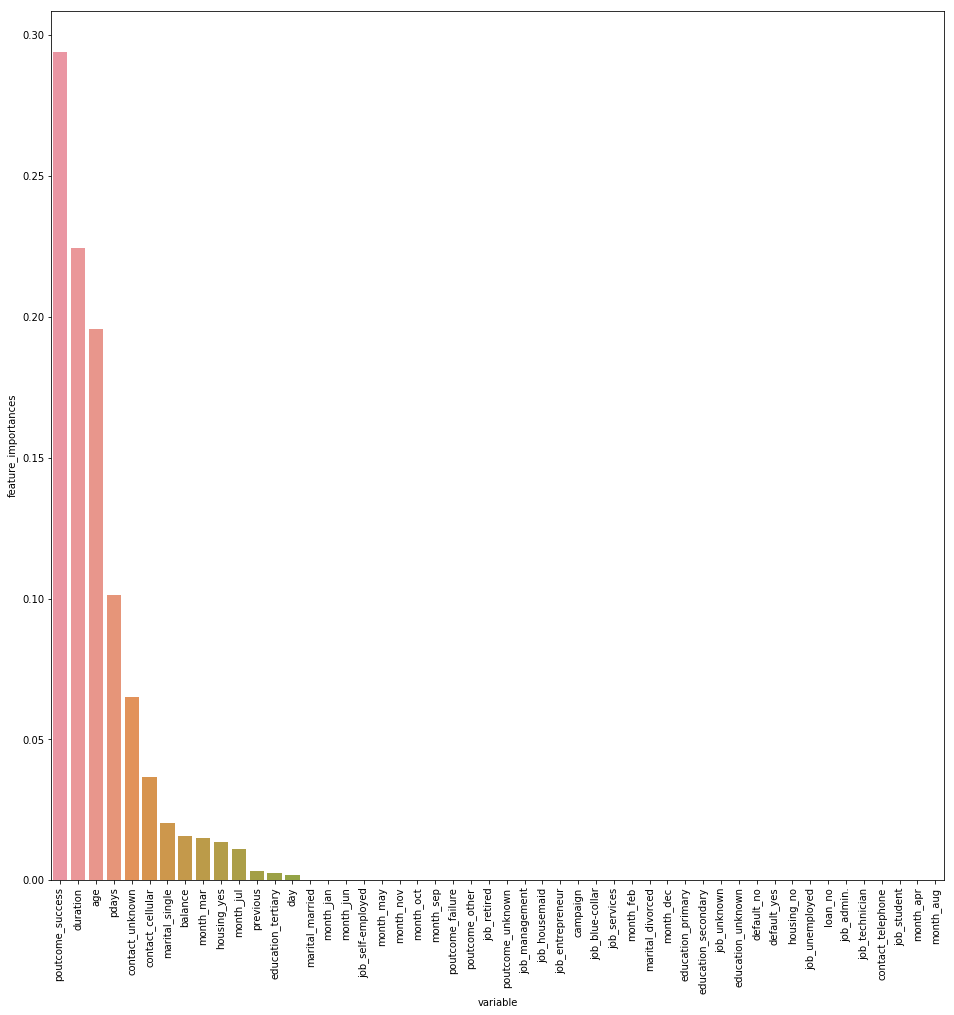

In [245]:
plt.figure(figsize=(16,16))
barplot = sns.barplot(data=first_50, y='feature_importances', x='variable')
_ = barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90)

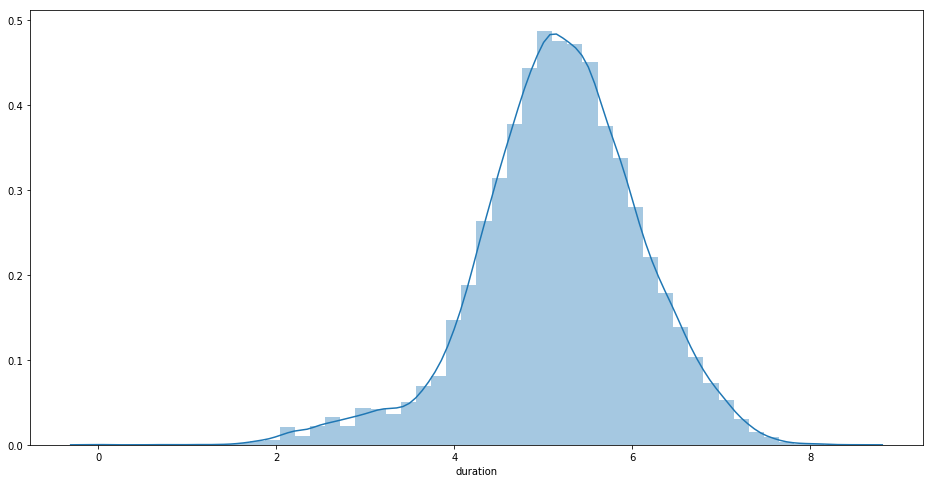

In [225]:
sns.distplot(np.log(1 + bank_data.duration))